## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [50]:
df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

In [51]:
#The duration of the experiment 
experiment_duration =(df.timestamp.min(),df.timestamp.max())
experiment_duration

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[(df.group=='treatment')&(df.landing_page == 'old_page')].shape[0]

1965

f. Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
mis_match=df[(df.group=='treatment')&(df.landing_page == 'old_page')|(df.group=='control')&(df.landing_page == 'new_page')]

In [9]:
df2=df.copy()

In [10]:
df2.drop(mis_match.index,inplace=True)

In [11]:
df2.shape

(290585, 5)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.user_id.duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop(2893,inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
(df2.converted == 1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
cond_prob1=df2.groupby(['group','converted']).size().unstack()
cond_prob1.apply(lambda x : x/x.sum(),axis=1) 
#answer 0.120386 , 0.118808

converted,0,1
group,,
control,0.879614,0.120386
treatment,0.881192,0.118808


In [19]:
p_cntrl_conv=df2.query("group == 'control'")['converted'].mean()
p_cntrl_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
p_treat_conv=df2.query("group == 'treatment'")['converted'].mean()
p_treat_conv

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
(df2.landing_page=='new_page').mean()

0.5000619442226688

In [22]:
obs_diff=p_treat_conv - p_cntrl_conv
obs_diff

-0.0015782389853555567

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**
from the observation above there isn't sufficient evidence, and the probability of conversion of the control is slightly higher than the probability of conversion of the treatment group...

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**  

$$ H_0: p_{new} - p_{old} <= 0 , H_1: p_{new}- p_{old} >0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
p_new=(df2.converted == 1).mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old=(df2.converted == 1).mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [25]:
n_new=df2[df2.landing_page == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [26]:
n_old=df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted=np.random.binomial(n_new,p_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted=np.random.binomial(n_old,p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
diff= new_page_converted/n_new -old_page_converted/n_old
diff

-0.0004767866448824598

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs.append(new_page_converted/n_new - old_page_converted/n_old)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [31]:
p_diffs=np.array(p_diffs)

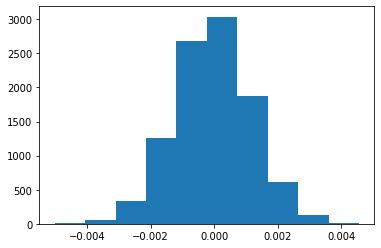

In [32]:
plt.hist(p_diffs);

In [33]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

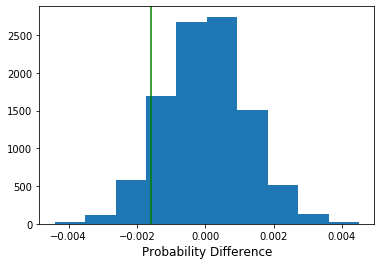

In [34]:
plt.hist(null_vals);
plt.xlabel("Probability Difference", fontsize=12)
plt.axvline(obs_diff, c='green');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [35]:
p_value=(p_diffs > obs_diff).mean()
p_value

0.9001

In [36]:
p_value < 0.05

False

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**
* This value is the p-value.
* The p-value is the conditional probability of data given that the null hypothesis is true. And we can reject the null hypothesis if the p-value is smaller than 0.05 - which is the null threshold -, however the case above shows that there isn't   sufficient evidence to reject the null because the p-value is greater than it, and the old page has more conversion than the new page similar to we have already known from observed data "the original sample".

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [42]:
import statsmodels.api as sm

convert_old = df2[(df.group == 'control')&(df.converted == 1)]['converted'].count()
convert_new = df2[(df.group == 'treatment')&(df.converted == 1)]['converted'].count()
n_old = df2[df.group == 'control']['group'].count()
n_new = df2[df.group == 'treatment']['group'].count()
convert_old ,convert_new,n_old,n_new

C:\Users\-TOSHIBA-\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\-TOSHIBA-\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\-TOSHIBA-\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\-TOSHIBA-\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [43]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value 

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.** 
A z-score is the number of standard deviations from the mean a data point is (obs_diff). The z-score and p-value computed in the previous question agree with the findings in parts **j.** and **k** (p-value is 0.9).

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.** Logistic Regression 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [46]:
df2['intercept']=1
df2["ab_page"]=pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [48]:
logistic_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [49]:
result= logistic_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 May 2021   Pseudo R-squ.:               8.077e-06
Time:                        04:49:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.** 
In regression, p-values are always given for testing if the parameter for the intercept or the slope are equal to zero with null hypothesis or not equal to zero with alternative hypothesis, and p-values with regression are useful because it shows if a particular variable is useful or not for predicting the response. 

We compare the null and hypothesis with p-value in A/B testing and regression as following:

* A/B:
$$
H_0: p-value < Alpha "0.05" reject the null 
H_1: p-value > 0.05   fail to reject the null 
$$

* Regression:
$$
H_0: p-value == 0
H_1: p-value  !=  0
$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

It's a good idea to add a features that can help us to enhance the accurcey of the model, However we should choose the variables which have 0 p-value for predicting the response.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [52]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [53]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [54]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [57]:
### Create the necessary dummy variables
df_new['country_dummy']=pd.get_dummies(df_new['country'])['US'] #here i'm only selecting Us and Uk, Us ==  1, Uk == 0 
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,country_dummy
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [60]:
### Fit Your Linear Model And Obtain the Results
log_mod=sm.Logit(df_new['converted'],df_new.iloc[:,-3:])
result=log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 10 May 2021   Pseudo R-squ.:               8.152e-06
Time:                        05:30:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.4201
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -1.9877      0.012   -167.205      0.000      -2.011      -1.964
ab_page          -0.0150      0.011     -1.311      0.190      -0.037       0.007
country_dummy    -0.0016      0.012     -0.126      0.900      -0.026       0.023
=================================================================================
"""

## Logistic regression with scikit-learn

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [62]:
df_new.columns

Index(['country', 'timestamp', 'group', 'landing_page', 'converted',
       'intercept', 'ab_page', 'country_dummy'],
      dtype='object')

In [80]:
X = df_new[['ab_page','country_dummy']]
y = df_new['converted']
X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.20, random_state=42)

In [81]:
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train)
preds = log_mod.predict(X_test)
confusion_matrix(y_test, preds) 

C:\Users\-TOSHIBA-\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[51129,     0],
       [ 6988,     0]], dtype=int64)

In [82]:
 precision_score(y_test, preds)

C:\Users\-TOSHIBA-\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [83]:
accuracy_score(y_test, preds)

0.8797597948965019

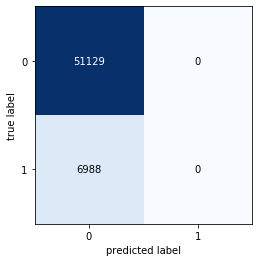

In [84]:
from mlxtend.plotting import plot_confusion_matrix
co_matr=confusion_matrix(y_test, preds) 
plot_confusion_matrix(co_matr);

# The plot above shows  that the algorithm can't classify the ones class because the data has already biased to zeros. 

<a id='conclusions'></a>
## Conclusions

* After A/B testing, we haven't sufficient evidence to say that new page has more conversion users than the old one, so we stay with the null hypothesis wich say that old page has a slightly more conversion users than the new page. 

* We can enhance our A/B testing by adding features that have a strong correlation with conversion, and the duration of the experiment should be longer. 
